
# O-zone Telecom – Employee Attrition & Workforce Stability Analysis  

## Business Context

O-zone Telecom is preparing for expansion into Africa but faces high attrition and absenteeism.
Two competing hypotheses:
• HR Manager → Gender-based inequality  
• Deputy → Systemic working condition issues  

Objectives:
1. Identify root causes  
2. Segment workforce risk  
3. Build predictive model  
4. Estimate financial impact  
5. Deliver business recommendations  


In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from scipy.stats import chi2_contingency


In [14]:

df = pd.read_csv('employee.csv')
df.shape
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1518 non-null   int64 
 1   Attrition                 1518 non-null   object
 2   BusinessTravel            1518 non-null   object
 3   DailyRate                 1518 non-null   int64 
 4   Department                1518 non-null   object
 5   DistanceFromHome          1518 non-null   int64 
 6   Education                 1518 non-null   int64 
 7   EducationField            1518 non-null   object
 8   EmployeeCount             1518 non-null   int64 
 9   EmployeeNumber            1518 non-null   int64 
 10  EnvironmentSatisfaction   1518 non-null   int64 
 11  Gender                    1518 non-null   object
 12  HourlyRate                1518 non-null   int64 
 13  JobInvolvement            1518 non-null   int64 
 14  JobLevel                

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [15]:

attrition_rate = (df['Attrition'] == 'Yes').mean()*100
print(f"Overall Attrition Rate: {attrition_rate:.2f}%")

Overall Attrition Rate: 16.34%


## Hypothesis Testing

In [16]:

cont_gender = pd.crosstab(df['Gender'], df['Attrition'])
chi2_g, p_g, _, _ = chi2_contingency(cont_gender)
print("Gender vs Attrition p-value:", p_g)

Gender vs Attrition p-value: 0.18534843176618399


In [17]:

cont_ot = pd.crosstab(df['OverTime'], df['Attrition'])
chi2_ot, p_ot, _, _ = chi2_contingency(cont_ot)
print("Overtime vs Attrition p-value:", p_ot)

Overtime vs Attrition p-value: 1.2366160687922384e-19


## PCA Analysis

In [18]:

df_pca = df.drop(columns=['EmployeeCount','EmployeeNumber','Over18','StandardHours'], errors='ignore')

le = LabelEncoder()
for col in df_pca.select_dtypes(include='object').columns:
    df_pca[col] = le.fit_transform(df_pca[col])

scaler = StandardScaler()
scaled = scaler.fit_transform(df_pca)

pca = PCA()
pca_result = pca.fit_transform(scaled)

pca.explained_variance_ratio_[:5]

array([0.15178517, 0.06132811, 0.0569451 , 0.05434836, 0.05113173])

## K-Means Clustering

In [24]:

pca_reduced = PCA(n_components=5).fit_transform(scaled)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_reduced)

df['Cluster'] = clusters

pd.crosstab(df['Cluster'], df['Attrition'], normalize='index')*100

c:\Users\kaush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Attrition,No,Yes
Cluster,,
0,80.097087,19.902913
1,80.199115,19.800885
2,93.137255,6.862745


## Decision Tree Model

Top 10 Features:
                    Feature  Importance
43             OverTime_Yes    0.164504
0                       Age    0.113463
22     YearsWithCurrManager    0.111895
7                  JobLevel    0.095137
39  JobRole_Sales Executive    0.079295
21  YearsSinceLastPromotion    0.054791
9             MonthlyIncome    0.054258
15         StockOptionLevel    0.047966
19           YearsAtCompany    0.043816
8           JobSatisfaction    0.038910


<Figure size 1000x600 with 0 Axes>

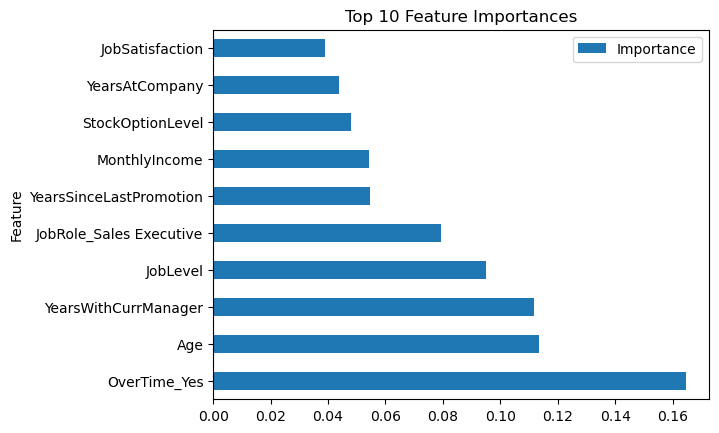

In [ ]:

# Drop non-predictive columns
df_model = df.drop(columns=['EmployeeCount',
                            'EmployeeNumber',
                            'Over18',
                            'StandardHours',
                            'Cluster'],
                   errors='ignore')

y = df_model['Attrition']
X = df_model.drop('Attrition', axis=1)

X = pd.get_dummies(X, drop_first=True)

if y.dtype == 'object':
    y = y.map({'Yes':1, 'No':0})

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

dt.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Features:")
print(feature_importance.head(10))

# Visualization
plt.figure(figsize=(10,6))
feature_importance.head(10).plot(x='Feature', y='Importance', kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       254
           1       0.33      0.52      0.41        50

    accuracy                           0.75       304
   macro avg       0.61      0.66      0.62       304
weighted avg       0.80      0.75      0.77       304



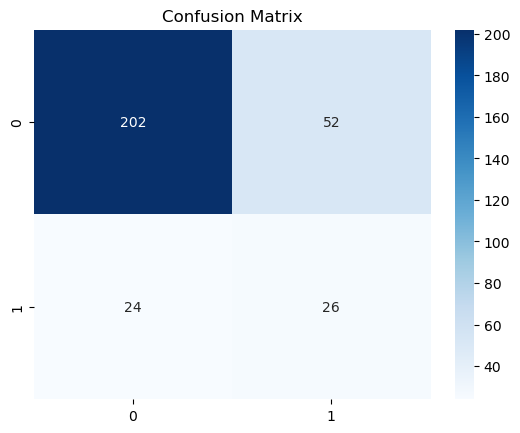

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

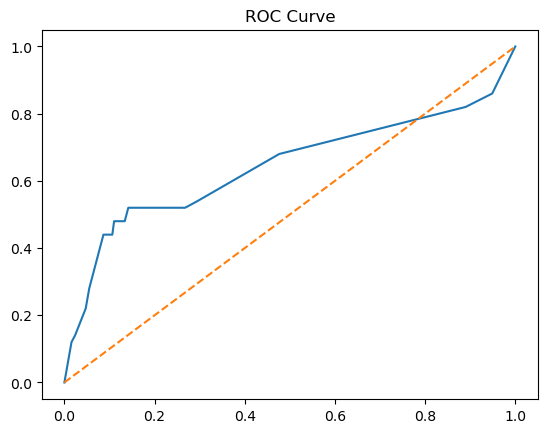

AUC: 0.6431102362204725


In [ ]:

y_prob = dt.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.show()

print("AUC:", roc_auc)

## Financial Impact Estimation

In [12]:

average_salary = df['MonthlyIncome'].mean()*12
replacement_rate = 0.5
attrition_count = (df['Attrition']=='Yes').sum()

total_cost = average_salary * replacement_rate * attrition_count
print(f"Estimated Annual Attrition Cost: €{total_cost:,.0f}")

Estimated Annual Attrition Cost: €9,683,459



## Strategic Recommendations

• Reduce overtime load  
• Improve compensation structures  
• Deploy predictive retention monitoring  
• Prepare stable workforce before African expansion  
